This notebook implements a submission with Gemma 3 12B IT model with some helper code to ensure the generated SVGs conform to the submission requirements. (See the [Evaluation](https://www.kaggle.com/competitions/drawing-with-llms/overview/evaluation) page for details on the submission requirements.)

To use this notebook interactively, you'll need to install some dependencies. First, *turn on* the Internet under **Session options** to the right. Then select the **Add-ons->Install Dependencies** menu above and click *Run*. A console should pop up with a running `pip` command. Wait for the dependencies to finish installing and then *turn off* the Internet before submitting.

In [1]:
ls /kaggle/input

d/  drawing-with-llms/  gemma-2/  gemma-3/  svg-constraints/


In [2]:
!pip install --upgrade bitsandbytes cairosvg google_re2 transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.8/546.8 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 105.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [3]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.5.1+cu121
True
2


In [4]:
#| default_exp core

In [5]:
#| export
import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree
from transformers import AutoTokenizer, BitsAndBytesConfig, Gemma3ForCausalLM

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):
        # Quantization Configuration
        # quantization_config = BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     bnb_4bit_quant_type="nf4",
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_compute_dtype=torch.float16,
        # )
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
        )
        
        self.model_path = kagglehub.model_download('google/gemma-3/transformers/gemma-3-4b-it/1')
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)

        # self.model = Gemma3ForCausalLM.from_pretrained(
        #     self.model_path,
        #     quantization_config=quantization_config,
        #     device_map="auto",
        #     low_cpu_mem_usage=True
        # )
        # self.model = Gemma3ForCausalLM.from_pretrained(
        #     self.model_path,
        #     quantization_config=quantization_config,
        #     device_map="auto"
        # )
        # Use float16 or bfloat16 to load the model
        self.model = Gemma3ForCausalLM.from_pretrained(
            self.model_path,
            device_map="auto",
            torch_dtype=torch.bfloat16,  # or torch.float16
        )
        self.model.gradient_checkpointing_enable()

        # print(self.model.hf_device_map)
        
        self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
#         self.prompt_template = """Generate high-quality SVG code to visually represent the given description. Ensure the design is clear, well-structured, and adheres to the specified constraints.
# <constraints>
# * **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
# * **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
# * **Code Requirements:**
#   * The generated SVG must be **valid, well-formed**, and free from errors.
#   * Ensure **correct positioning and scaling** to maintain visual balance.
#   * Use **appropriate colors, shapes, and proportions** to best represent the description.
#   * Avoid unnecessary complexity while ensuring visual accuracy.
#   * The output should be **self-contained and complete**—never use placeholders or omit parts.

# <example>
# <description>"A red circle with a blue square inside, centered within a 256x256 canvas"</description>
# ```svg
# <svg viewBox="0 0 256 256" width="256" height="256" xmlns="http://www.w3.org/2000/svg">
#   <circle cx="128" cy="128" r="60" fill="red"/>
#   <rect x="98" y="98" width="60" height="60" fill="blue"/>
# </svg>
# ```
# </example>


# Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

# <description>"{}"</description>
# ```svg
# <svg viewBox="0 0 256 256" width="256" height="256">
# """
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 900

    
    
    # You could try increasing `max_new_tokens`
    def predict(self, description: str, max_new_tokens=512) -> str:
        def generate_svg():
            try:
                prompt = self.prompt_template.format(description)

                input_ids_0 = self.tokenizer(text=prompt, return_tensors="pt").to(DEVICE)

                # Clear the GPU cache before generating
                torch.cuda.empty_cache()
                try:
                    with torch.no_grad():
                        outputs = self.model.generate(
                            **input_ids_0, 
                            max_new_tokens=max_new_tokens,
                            do_sample=True,
                        )
                except Exception as e:
                    logging.error('Exception during output generation: %s', e)
                    # print('Exception during output generation: %s', e)

                # print('Outputs from model: %s', outputs)
                output_decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                
                logging.debug('Output decoded from model: %s', output_decoded)
                # print('Output decoded from model: %s', output_decoded)

                matches = re.findall(r"<svg.*?</svg>", output_decoded, re.DOTALL | re.IGNORECASE)
                if matches:
                    svg = matches[-1]
                else:
                    return self.default_svg

                logging.debug('Unprocessed SVG: %s', svg)
                svg = self.enforce_constraints(svg)
                logging.debug('Processed SVG: %s', svg)
                # Ensure the generated code can be converted by cairosvg
                cairosvg.svg2png(bytestring=svg.encode('utf-8'))
                return svg
            except Exception as e:
                logging.error('Exception during SVG generation: %s', e)
                # print('Exception during SVG generation: %s', e)
                return self.default_svg

        # Execute SVG generation in a new thread to enforce time constraints
        with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
            future = executor.submit(generate_svg)
            try:
                return future.result(timeout=self.timeout_seconds)
            except concurrent.futures.TimeoutError:
                logging.warning("Prediction timed out after %s seconds.", self.timeout_seconds)
                return self.default_svg
            except Exception as e:
                logging.error(f"An unexpected error occurred: {e}")
                return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

The following code tests the above model in a local mock-up of this competition's evaluation pipeline. It runs the model on a sample of 15 instances defined in the `test.csv` file in the `kaggle_evaluation` package folder.

In [6]:
import kaggle_evaluation

logging.basicConfig(level=logging.INFO, force=True)
kaggle_evaluation.test(Model)

Creating Model instance...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Running inference tests...
Wrote test submission file to "/tmp/kaggle-evaluation-submission-14tb6sxt.csv".
Success!


Alternatively, you could use the code below to run the model over `train.csv` and see some generated images along with some debugging info. Feel free to turn down the logging level to `INFO` if you just want to see the images.

id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dp.kaggle.net:443
DEBUG:urllib3.connectionpool:https://dp.kaggle.net:443 "POST /kaggle-jwt-handler/AttachDatasourceUsingJwtRequest HTTP/1.1" 200 None


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a purple forest at d...': 16.3394 seconds


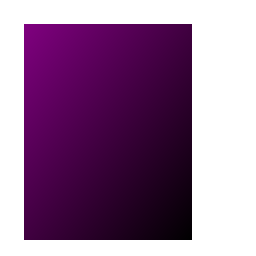

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'gray wool coat with ...': 10.9214 seconds


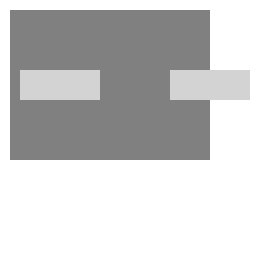

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a lighthouse overloo...': 13.9142 seconds


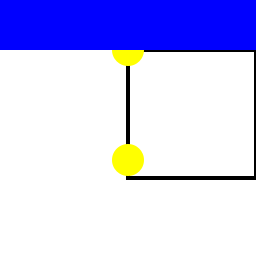

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'burgundy corduroy pa...': 16.2660 seconds


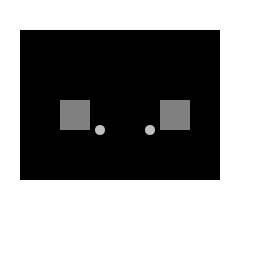

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'orange corduroy over...': 16.2090 seconds


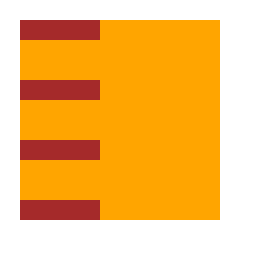

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a purple silk scarf ...': 15.4995 seconds


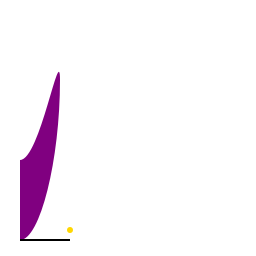

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a green lagoon under...': 11.9352 seconds


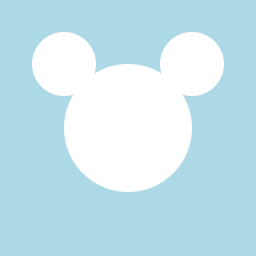

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'crimson rectangles f...': 19.9355 seconds


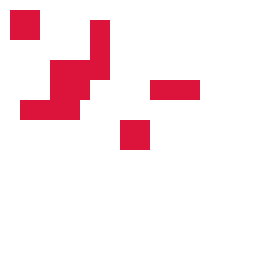

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'purple pyramids spir...': 19.2443 seconds


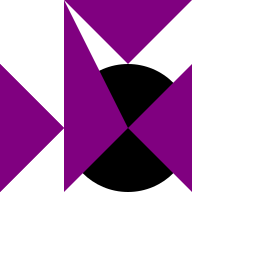

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'magenta trapezoids l...': 25.8018 seconds


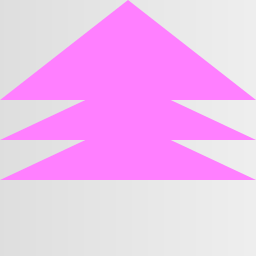

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a snowy plain...': 11.2315 seconds


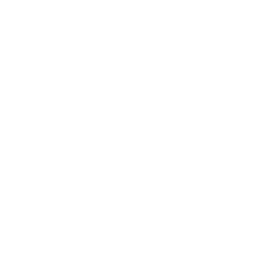

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'black and white chec...': 31.7692 seconds


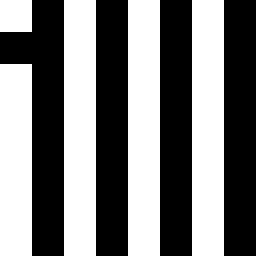

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a starlit night over...': 24.3241 seconds


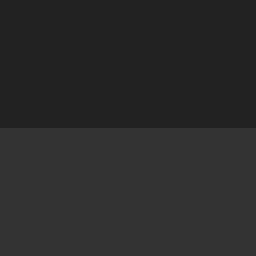

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'khaki triangles and ...': 8.1120 seconds


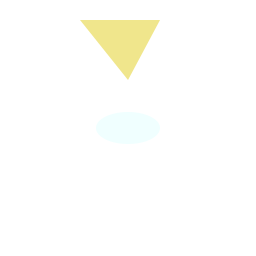

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a maroon dodecahedro...': 32.6515 seconds


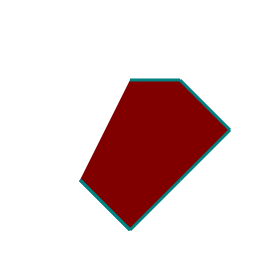

Total prediction time: 274.1546 seconds
Average prediction time: 18.2770 seconds


In [8]:
def generate():
    import polars as pl
    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.DEBUG, force=True)
    
    train = pl.read_csv('/kaggle/input/drawing-with-llms/train.csv')
    display(train.head())
    
    model = Model()
    svgs = []
    total_pred_time = 0.0
    inf_cnt = 0
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc, max_new_tokens=512)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
    
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

        total_pred_time += elapsed_time
        inf_cnt += 1


    print(f"Total prediction time: {total_pred_time:.4f} seconds")
    print(f"Average prediction time: {total_pred_time/inf_cnt:.4f} seconds")
        

# Uncomment and run the line below to see some generated images
generate()